The object here is to train a machine learning model on a database of Tweets and use that model to predict sentiment of Tweets from a user, a hashtag, or any random variety of Tweets. 

**@author Ryan Herren**

**@author Tanner Dunn**

The following link is a good informational guide on how to roughly implement a model like we are aiming for. https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

# Initialize environment, install packages

In [162]:
import tweepy
import pandas as pd
import numpy as np
import operator 
import json
from collections import Counter
import os
import yaml
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import math
import time
from tqdm import tqdm
import seaborn as sns
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanherren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
os.environ['python-bot-config'] = "/Users/ryanherren/python-bot-config.yaml"
# os.environ['python-bot-config'] = "/Users/dunnt/python-bot-config.yaml"
# os.environ['python-bot-config'] = "/Users/mariolgw/python-bot-config.yaml"

In [35]:
try:
    v_env = os.environ['python-bot-config']
except:
    print("Config file env variable is not set.")
    print("Set python-bot-config file")
    sys.exit(1)

with open(v_env, "r") as yamlConfig:
    cfg = yaml.safe_load(yamlConfig)

# Import Opinion Lexicon

In [36]:
# Reading negative words list:
with open('negative-words.txt', 'r', encoding = "ISO-8859-1") as t:
    neg = t.readlines()
    neg_words = []
    for i in neg:
        neg_words.append(i.strip())
    del neg_words[0 : 31]
    

# Reading positive words list:
with open('positive-words.txt', 'r', encoding = "ISO-8859-1") as t:
    pos = t.readlines()
    pos_words = []
    for i in pos:
        pos_words.append(i.strip())
    del pos_words[0 : 30]
    
positive_emojis = ['😂','🔥','😍','🤘','🤩','👍','💯','😎','✅','👏','😀','🐐',
                   '❤️','♥️','😘','😊','😄','😃','😆','😋','🤪','😜','😛','🤑']
negative_emojis = ['🥴','🤢','🤮','😧','😑','😰','🤬','😡','😭','😢','😩','🙁',
                   '☹️','😣','😖','😫','😟','😞','😔','😒','👿','🤕','🤒','😷']

# Function to count sentiment words in Tweets

In [37]:
# Function to count negative words in tweet:
def count_negative(tweet):
    neg_word_count = 0
    for word in tweet:
        if word.lower() in neg_words:
            neg_word_count = neg_word_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return neg_word_count
   
# Function to count positive words in tweet:
def count_positive(tweet):
    pos_word_count = 0
    for word in tweet:
        #print(word)
        if word.lower() in pos_words:
            pos_word_count = pos_word_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return pos_word_count
   
def count_mentions(tweet):
    num_mentions = 0
    for word in tweet:
        if word.startswith('@'):
            num_mentions = num_mentions + 1
    return num_mentions

def count_hashtags(tweet):
    num_hashtags = 0
    for word in tweet:
        if word.startswith('#'):
            num_hashtags = num_hashtags + 1
    return num_hashtags

def count_positive_emojis(tweet):
    pos_emoji_count = 0
    for word in tweet:
        #print(word)
        if word in positive_emojis:
            pos_emoji_count = pos_emoji_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return pos_emoji_count

def count_negative_emojis(tweet):
    neg_emoji_count = 0
    for word in tweet:
        #print(word)
        if word in negative_emojis:
            neg_emoji_count = neg_emoji_count + 1
            # mg['neg_word_count'] = mg['text'].apply(lambda x: neg_word_count(x), axis = 1, result_type = 'expand')
    return neg_emoji_count

# Tokenizing functions to break tweets into words, emojis, mentions, and hashtags

In [38]:
# This cell is the basis of how tokenizing the Tweet will work. Using regex statments, it accounts for emojis, 
# hashtags, mentions, and more.
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

# Configure Twitter API Connection

In [39]:
consumer_key = cfg.get("TwitterAPI").get("consumer_key")
consumer_secret = cfg.get("TwitterAPI").get("consumer_secret")
access_token = cfg.get("TwitterAPI").get("access_token")
access_token_secret = cfg.get("TwitterAPI").get("access_token_secret")

In [40]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

# Get Tweets by User

In [41]:
# Currently limited to num_tweets Tweets
column_names = ['tweet_id', 'text','created_at']
def get_tweets_by_user(user, tweets):
    tweet_json = pd.DataFrame(columns=column_names)
    for i in range(math.ceil(tweets/20)):
        tweets = api.user_timeline(user, page=i)
#         print(str(i) + "WABBADABBADO\n")
#         print(tweets)
        my_list_of_dicts = []
        for each_json_tweet in tweets:
            my_list_of_dicts.append(each_json_tweet._json)
        filename = user + '.txt'
        if os.path.exists(filename):
            os.remove(filename)
        with open(filename, 'w') as file:
            file.write(json.dumps(my_list_of_dicts, indent=4))
        my_demo_list = []
        with open(filename, encoding='utf-8') as json_file:  
            all_data = json.load(json_file)
            for each_dictionary in all_data:
                tweet_id = each_dictionary['id']
                text = each_dictionary['text']
                favorite_count = each_dictionary['favorite_count']
                retweet_count = each_dictionary['retweet_count']
                created_at = each_dictionary['created_at']
                my_demo_list.append({'tweet_id': str(tweet_id),
                                     'text': str(text),
                                     'created_at': created_at,
                                    })
                #print(my_demo_list)
                temp_json = pd.DataFrame(my_demo_list, columns = 
                                          ['tweet_id', 'text', 
                                           'created_at'])
#             print("\n \n " + str(temp_json.shape) + str(type(temp_json)) + "\n\n")
        tweet_json = tweet_json.append(temp_json, ignore_index=True)
#         print("\n \n " + str(tweet_json.shape) + str(type(tweet_json)) + "\n\n")
    tweet_json = tweet_json.drop_duplicates()    
    return tweet_json

# Get Tweets by Hashtag

In [42]:
# TODO

# Loading in Training Data from Kaggle

In [43]:
# TODO
# https://www.kaggle.com/kazanova/sentiment140
# Download this dataset (~230mb) to your project directory
# Once this is done, begin training models

# 0 is negative
# 2 is neutral
# 4 is positive

# This dataset does not have any emojis, so we will have to find an alternative way if 
# we want to evaluate the effects that emojis have on sentiment

In [187]:
training_cnames = ['sentiment', 'tweet_id', 'created_at', 'mention', 'author', 'text']

training_data_full = pd.read_csv('training.1600000.processed.noemoticon.csv', names = training_cnames, encoding='latin-1')

training_data_full = training_data[['sentiment', 'tweet_id', 'created_at', 'text']]

In [238]:
# You can use this to slim down the data set.
# Loading and manipulating the full dataset takes about 30 minutes
# Pulling in 15000 tweets takes ~18 seconds to manipulate and will give a sufficient
# training set to use
training_data = training_data_full.sample(15000)

In [239]:
start = time.time()
training_data['tokenized'] = training_data['text'].apply(lambda x: tokenize(x))
training_data['pos_words'] = training_data['tokenized'].apply(lambda x: count_positive(x))
training_data['neg_words'] = training_data['tokenized'].apply(lambda x: count_negative(x))
training_data['num_mentions'] = training_data['tokenized'].apply(lambda x: count_mentions(x))
training_data['num_hashtags'] = training_data['tokenized'].apply(lambda x: count_hashtags(x))
training_data['num_positive_emojis'] = training_data['tokenized'].apply(lambda x: count_positive_emojis(x))
training_data['num_negative_emojis'] = training_data['tokenized'].apply(lambda x: count_negative_emojis(x))
end = time.time()
print(end - start)

18.779901027679443


In [240]:
training_data

,sentiment,tweet_id,created_at,text,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
1450577,positive,2062954176,Sun Jun 07 00:51:49 PDT 2009,The sound of sleep sounds great after a day of...,"[The, sound, of, sleep, sounds, great, after, ...",2,1,0,0,0,0
489066,positive,2182850127,Mon Jun 15 13:43:03 PDT 2009,Anyone going to America this week? I want the ...,"[Anyone, going, to, America, this, week, ?, I,...",1,0,0,0,0,0
209650,positive,1974033197,Sat May 30 12:18:27 PDT 2009,"So bright outside! I want my skim board, but I...","[So, bright, outside, !, I, want, my, skim, bo...",1,0,0,0,0,0
811160,positive,1469983368,Tue Apr 07 08:00:13 PDT 2009,I am going to record our first Video for the n...,"[I, am, going, to, record, our, first, Video, ...",1,0,0,0,0,0
1279032,positive,2001495867,Tue Jun 02 01:04:27 PDT 2009,"@ventureweb heh, no doubt! I've got a pretty g...","[@ventureweb, heh, ,, no, doubt, !, I've, got,...",2,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
448838,negative,2069095774,Sun Jun 07 15:15:14 PDT 2009,"@cartab no I am on my Nokia E71. Worse, I am i...","[@cartab, no, I, am, on, my, Nokia, E71, ., Wo...",0,1,1,0,0,0
635716,positive,2233706767,Thu Jun 18 21:46:17 PDT 2009,http://bit.ly/MahXC - George is leaving Grey's,"[http://bit.ly/MahXC, -, George, is, leaving, ...",0,0,0,0,0,0
1209645,positive,1988958271,Sun May 31 23:53:39 PDT 2009,Woken by The Killers on a Monday- 'i got soul ...,"[Woken, by, The, Killers, on, a, Monday, -, ',...",1,0,0,0,0,0
973978,negative,1833313518,Sun May 17 22:54:26 PDT 2009,working on a stuffed owl its green and spotty,"[working, on, a, stuffed, owl, its, green, and...",0,1,0,0,0,0


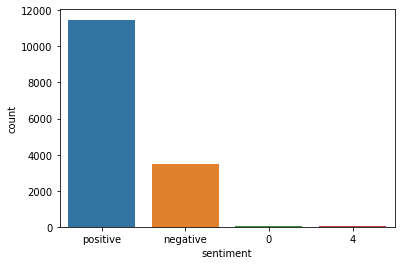

In [241]:
sns.countplot(x='sentiment', data=training_data)

# Load in Emoji Training Data from DS301 Bot Timeline

In [242]:
training_data_emojis = get_tweets_by_user('DS301Bot', 100)
training_data_emojis['tokenized'] = training_data_emojis['text'].apply(lambda x: tokenize(x))
training_data_emojis['pos_words'] = training_data_emojis['tokenized'].apply(lambda x: count_positive(x))
training_data_emojis['neg_words'] = training_data_emojis['tokenized'].apply(lambda x: count_negative(x))
training_data_emojis['num_mentions'] = training_data_emojis['tokenized'].apply(lambda x: count_mentions(x))
training_data_emojis['num_hashtags'] = training_data_emojis['tokenized'].apply(lambda x: count_hashtags(x))
training_data_emojis['num_positive_emojis'] = training_data_emojis['tokenized'].apply(lambda x: count_positive_emojis(x))
training_data_emojis['num_negative_emojis'] = training_data_emojis['tokenized'].apply(lambda x: count_negative_emojis(x))

In [243]:
training_data_emojis

,tweet_id,text,created_at,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
0,1467703601913077760,A+ on my Data Science final? Perfect. ✅,Mon Dec 06 03:53:01 +0000 2021,"[A, +, on, my, Data, Science, final, ?, Perfec...",1,0,0,0,1,0
1,1467703471000412168,I love rock n' roll 🤘,Mon Dec 06 03:52:30 +0000 2021,"[I, love, rock, n, ', roll, 🤘]",1,0,0,0,1,0
2,1467703361424216072,I am sick. COVID sucks. 😷,Mon Dec 06 03:52:04 +0000 2021,"[I, am, sick, ., COVID, sucks, ., 😷]",0,2,0,0,0,1
3,1467702988101898242,I am so pissed off that there is not any snowf...,Mon Dec 06 03:50:35 +0000 2021,"[I, am, so, pissed, off, that, there, is, not,...",0,1,0,0,0,0
4,1467702798032777218,It is cold outside and I am really mad about i...,Mon Dec 06 03:49:50 +0000 2021,"[It, is, cold, outside, and, I, am, really, ma...",1,2,0,0,0,1
5,1467702582416220163,"Breathe deep darling, you're gonna be alright....",Mon Dec 06 03:48:58 +0000 2021,"[Breathe, deep, darling, ,, you're, gonna, be,...",1,0,0,0,0,0
6,1467687257171795970,If I tell you I don't like something and you c...,Mon Dec 06 02:48:05 +0000 2021,"[If, I, tell, you, I, don't, like, something, ...",1,1,0,0,0,1
7,1467686277030064133,What a bad day. 😞,Mon Dec 06 02:44:11 +0000 2021,"[What, a, bad, day, ., 😞]",0,1,0,0,0,1
8,1467684957514567684,What a good day. 😄,Mon Dec 06 02:38:56 +0000 2021,"[What, a, good, day, ., 😄]",1,0,0,0,1,0
9,1467684474855075844,Phil Hellmuth is one of the most legendary pok...,Mon Dec 06 02:37:01 +0000 2021,"[Phil, Hellmuth, is, one, of, the, most, legen...",1,0,0,0,0,0


In [244]:
# Custom sentiment assignments for tweets with emojis
emojis_sentiment = [4,4,0,0,0,4,0,0,4,4,4,4,0,4,4,4,0,4,4,4,0,0,4,0,4,0,4,0,0,4,0,0,0,4,4,4,0,4,4]

In [245]:
training_data_emojis.insert(0, 'sentiment', emojis_sentiment)

In [246]:
training_data = training_data.append(training_data_emojis)

In [247]:
training_data

,sentiment,tweet_id,created_at,text,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
1450577,positive,2062954176,Sun Jun 07 00:51:49 PDT 2009,The sound of sleep sounds great after a day of...,"[The, sound, of, sleep, sounds, great, after, ...",2,1,0,0,0,0
489066,positive,2182850127,Mon Jun 15 13:43:03 PDT 2009,Anyone going to America this week? I want the ...,"[Anyone, going, to, America, this, week, ?, I,...",1,0,0,0,0,0
209650,positive,1974033197,Sat May 30 12:18:27 PDT 2009,"So bright outside! I want my skim board, but I...","[So, bright, outside, !, I, want, my, skim, bo...",1,0,0,0,0,0
811160,positive,1469983368,Tue Apr 07 08:00:13 PDT 2009,I am going to record our first Video for the n...,"[I, am, going, to, record, our, first, Video, ...",1,0,0,0,0,0
1279032,positive,2001495867,Tue Jun 02 01:04:27 PDT 2009,"@ventureweb heh, no doubt! I've got a pretty g...","[@ventureweb, heh, ,, no, doubt, !, I've, got,...",2,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
54,4,1467634159027822597,Sun Dec 05 23:17:05 +0000 2021,Ethereum is going to be the best asset on the ...,"[Ethereum, is, going, to, be, the, best, asset...",1,0,0,0,2,0
55,4,1467633730864910340,Sun Dec 05 23:15:23 +0000 2021,"Live, laugh, love ❤️","[Live, ,, laugh, ,, love, ❤, ️]",1,0,0,0,0,0
56,0,1467633636904079362,Sun Dec 05 23:15:01 +0000 2021,"Oklahoma sucks, everyone I know hates Oklahoma 👿","[Oklahoma, sucks, ,, everyone, I, know, hates,...",0,2,0,0,0,1
57,4,1467633503663656960,Sun Dec 05 23:14:29 +0000 2021,"I love Brock Purdy, he’s the best! 🐐","[I, love, Brock, Purdy, ,, he, ’, s, the, best...",2,0,0,0,1,0


In [248]:
training_data['pos_total'] = training_data['pos_words'] + training_data['num_positive_emojis']
training_data['neg_total'] = training_data['neg_words'] + training_data['num_negative_emojis']

In [249]:
training_data

,sentiment,tweet_id,created_at,text,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis,pos_total,neg_total
1450577,positive,2062954176,Sun Jun 07 00:51:49 PDT 2009,The sound of sleep sounds great after a day of...,"[The, sound, of, sleep, sounds, great, after, ...",2,1,0,0,0,0,2,1
489066,positive,2182850127,Mon Jun 15 13:43:03 PDT 2009,Anyone going to America this week? I want the ...,"[Anyone, going, to, America, this, week, ?, I,...",1,0,0,0,0,0,1,0
209650,positive,1974033197,Sat May 30 12:18:27 PDT 2009,"So bright outside! I want my skim board, but I...","[So, bright, outside, !, I, want, my, skim, bo...",1,0,0,0,0,0,1,0
811160,positive,1469983368,Tue Apr 07 08:00:13 PDT 2009,I am going to record our first Video for the n...,"[I, am, going, to, record, our, first, Video, ...",1,0,0,0,0,0,1,0
1279032,positive,2001495867,Tue Jun 02 01:04:27 PDT 2009,"@ventureweb heh, no doubt! I've got a pretty g...","[@ventureweb, heh, ,, no, doubt, !, I've, got,...",2,1,1,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,4,1467634159027822597,Sun Dec 05 23:17:05 +0000 2021,Ethereum is going to be the best asset on the ...,"[Ethereum, is, going, to, be, the, best, asset...",1,0,0,0,2,0,3,0
55,4,1467633730864910340,Sun Dec 05 23:15:23 +0000 2021,"Live, laugh, love ❤️","[Live, ,, laugh, ,, love, ❤, ️]",1,0,0,0,0,0,1,0
56,0,1467633636904079362,Sun Dec 05 23:15:01 +0000 2021,"Oklahoma sucks, everyone I know hates Oklahoma 👿","[Oklahoma, sucks, ,, everyone, I, know, hates,...",0,2,0,0,0,1,0,3
57,4,1467633503663656960,Sun Dec 05 23:14:29 +0000 2021,"I love Brock Purdy, he’s the best! 🐐","[I, love, Brock, Purdy, ,, he, ’, s, the, best...",2,0,0,0,1,0,3,0


In [250]:
def standardize_sentiment(x, y):
#     print(row['pos_total'])
    if x > y:
        ret = 'positive'
    elif x < y:
        ret = 'negative'
    elif x == y:
        rando = random.randint(0, 1)
        if rando == 1:
            ret = 'negative'
        else:
            ret = 'positive'
    return ret

In [251]:
sentiment1 = []
for index, row in training_data.iterrows():
    x = row['pos_total']
    y = row['neg_total']
    sentiment1.append(standardize_sentiment(x, y))

In [252]:
training_data = training_data.drop(columns='sentiment')
training_data.insert(0, 'sentiment', sentiment1)

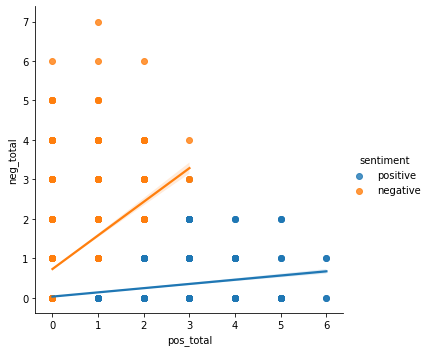

In [253]:
sns.lmplot('pos_total', 'neg_total', data = training_data, hue = 'sentiment')

# Train ML Models on Training Data

In [254]:
# SVM

In [255]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics

In [256]:
svm_X = training_data[['pos_total', 'neg_total']].to_numpy()
# svm_X = training_data[['pos_words', 'neg_words', 'num_positive_emojis', 'num_negative_emojis']].to_numpy()
svm_y = training_data[['sentiment']].to_numpy()

In [257]:
x_train, x_test, y_train, y_test = train_test_split(svm_X, svm_y)
model = SVC(kernel= 'linear').fit(x_train, y_train)

/Users/ryanherren/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [258]:
accuracy = model.score(x_test,y_test)
accuracy

0.7792553191489362

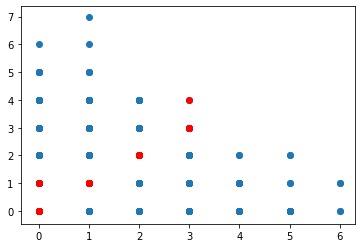

In [260]:
import matplotlib.pyplot as plt
support_vectors = model.support_vectors_

b = model.intercept_[0]
w1, w2 = model.coef_.T
c= -b/w2
m = -w1/w2
xmin, xmax = 0, 10.0
ymin, ymax = 0, 10.0
xd = np.array([xmin, xmax])
yd = m*xd + c
# plt.plot(xd, yd, 'k', lw=1, ls='--')
# plt.fill_between(xd, yd, ymin, color = 'tab:red', alpha = .2)
# plt.fill_between(xd, yd, ymax, color='tab:green', alpha = .2)

plt.scatter(x_train[:,0], x_train[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color = 'red')
plt.show()

# Experimentation

In [55]:
user_tweets = get_tweets_by_user('CycloneLarry69', 109)

In [58]:
user_tweets['tokenized'] = user_tweets['text'].apply(lambda x: tokenize(x))
user_tweets['pos_words'] = user_tweets['tokenized'].apply(lambda x: count_positive(x))
user_tweets['neg_words'] = user_tweets['tokenized'].apply(lambda x: count_negative(x))
user_tweets['num_mentions'] = user_tweets['tokenized'].apply(lambda x: count_mentions(x))
user_tweets['num_hashtags'] = user_tweets['tokenized'].apply(lambda x: count_hashtags(x))
user_tweets['num_positive_emojis'] = user_tweets['tokenized'].apply(lambda x: count_positive_emojis(x))
user_tweets['num_negative_emojis'] = user_tweets['tokenized'].apply(lambda x: count_negative_emojis(x))

In [59]:
user_tweets

,tweet_id,text,created_at,tokenized,pos_words,neg_words,num_mentions,num_hashtags,num_positive_emojis,num_negative_emojis
0,1467702232380493826,Iowa State football is favored in a post seaso...,Mon Dec 06 03:47:35 +0000 2021,"[Iowa, State, football, is, favored, in, a, po...",1,0,0,0,0,0
1,1467700179847589899,Coincidence that he jumped ship only a few hou...,Mon Dec 06 03:39:26 +0000 2021,"[Coincidence, that, he, jumped, ship, only, a,...",0,0,0,0,0,0
2,1467679345451974664,Lol imagine telling an Iowa State fan in 2015 ...,Mon Dec 06 02:16:38 +0000 2021,"[Lol, imagine, telling, an, Iowa, State, fan, ...",0,0,0,0,0,0
3,1467678904357904386,@travisclones You’d be crazy not to,Mon Dec 06 02:14:53 +0000 2021,"[@travisclones, You, ’, d, be, crazy, not, to]",0,1,1,0,0,0
4,1467648646250483713,@itshanklol Hateful 8 stays winning baby,Mon Dec 06 00:14:39 +0000 2021,"[@itshanklol, Hateful, 8, stays, winning, baby]",1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
115,1467297371985952776,Football was meant to be played in 30 degree w...,Sun Dec 05 00:58:49 +0000 2021,"[Football, was, meant, to, be, played, in, 30,...",0,0,0,0,0,0
116,1467289345791086596,We are all Bearcats now,Sun Dec 05 00:26:55 +0000 2021,"[We, are, all, Bearcats, now]",0,0,0,0,0,0
117,1467283257205178368,1. Alabama\n2. Michigan\n3. Cincy\n4. Notre Da...,Sun Dec 05 00:02:43 +0000 2021,"[1, ., Alabama, 2, ., Michigan, 3, ., Cincy, 4...",0,0,0,0,0,0
118,1467275698855456770,Don’t put Georgia in,Sat Dec 04 23:32:41 +0000 2021,"[Don, ’, t, put, Georgia, in]",0,0,0,0,0,0


In [62]:
# punctuation = list(string.punctuation)
# stop = stopwords.words('english') + punctuation + ['rt', 'via', '’', 'RT', '️', '…']

In [63]:
# count_all = Counter()
# for tweet in user_tweets['text']:
#     terms_all = [term for term in preprocess(tweet)]
#     terms_stop = [term for term in preprocess(tweet) if term not in stop]
#     count_all.update(terms_stop)
#     print(tweet + "\n")
# print(count_all.most_common(10))